In [1]:
from os.path import dirname, join, abspath
from pyrep import PyRep
from pyrep.robots.arms.baxter import BaxterLeft, BaxterRight
from pyrep.robots.end_effectors.baxter_gripper import BaxterGripper
from pyrep.objects.dummy import Dummy
from pyrep.objects.shape import Shape

from pyrep.objects.joint import Joint
from pyrep.objects.object import Object
from pyrep.objects.vision_sensor import VisionSensor
import transforms3d.quaternions as quaternions
import transforms3d.euler as euler

import numpy as np
import time
import matplotlib.pyplot as plt
import cv2
import pickle
from pyrep.backend import sim
import glob

In [2]:
def get_camera_matrix(x_resolution = 640, y_resolution = 480, fov = np.pi/3):
    if (x_resolution/y_resolution) > 1:
        fov_x = fov
        fov_y = 2 * np.arctan(np.tan(fov/2) / (x_resolution/y_resolution))
        print(fov_y)
    else:
        fov_x = 2 * np.arctan(np.tan(fov/2) / (x_resolution/y_resolution))
        fov_y = fov
    P = np.array([[-(x_resolution/2)/np.tan(0.5*fov_x),0,(x_resolution/2)],
                  [0,-(y_resolution/2)/np.tan(0.5*fov_y),(y_resolution/2)],
                  [0,0,1]])
    return P


def get_inverse_pose_vrep(pose):
    R_t = np.linalg.inv(pose)
    t = R_t[:3,3]
    quat_tmp = quaternions.mat2quat(R_t[:3,:3])
    quat = [quat_tmp[1],quat_tmp[2],quat_tmp[3],quat_tmp[0]]
    pose = np.concatenate((t.reshape(-1),quat))
    return pose


In [3]:
SCENE_FILE = 'spot_1.ttt'

pr = PyRep()

pr.launch(SCENE_FILE, headless=True)
pr.start()
front_left_hip_x = Joint("front_left_hip_x")
front_left_hip_y = Joint("front_left_hip_y")
front_left_knee = Joint("front_left_knee")

front_right_hip_x = Joint("front_right_hip_x")
front_right_hip_y = Joint("front_right_hip_y")
front_right_knee = Joint("front_right_knee")

rear_left_hip_x = Joint("rear_left_hip_x")
rear_left_hip_y = Joint("rear_left_hip_y")
rear_left_knee = Joint("rear_left_knee")

rear_right_hip_x = Joint("rear_right_hip_x")
rear_right_hip_y = Joint("rear_right_hip_y")
rear_right_knee = Joint("rear_right_knee")

base_link_visual = Shape("base_link_visual")


cam_8 = VisionSensor("Vision_sensor8")
cam_0 = VisionSensor("Vision_sensor0")

pr.step()

In [4]:

prediction = np.load("../state_estimation/outputs/spot_x.npy")
cam_para = np.load("../state_estimation/outputs/spot_c.npy")
fov = np.load("../state_estimation/outputs/spot_k.npy")

In [5]:
def setting_pose_in_sim(idx):
    joint_postions = prediction[idx]
    front_left_hip_x.set_joint_target_position(joint_postions[0])
    front_left_hip_y.set_joint_target_position(joint_postions[1])
    front_left_knee.set_joint_target_position(joint_postions[2])
    front_right_hip_x.set_joint_target_position(joint_postions[3])
    front_right_hip_y.set_joint_target_position(joint_postions[4])
    front_right_knee.set_joint_target_position(joint_postions[5])
    rear_left_hip_x.set_joint_target_position(joint_postions[6])
    rear_left_hip_y.set_joint_target_position(joint_postions[7])
    rear_left_knee.set_joint_target_position(joint_postions[8])
    rear_right_hip_x.set_joint_target_position(joint_postions[9])
    rear_right_hip_y.set_joint_target_position(joint_postions[10])
    rear_right_knee.set_joint_target_position(joint_postions[11])

    rvec = cam_para[idx,:3]
    tvec = cam_para[idx,3:]
    R,_ = cv2.Rodrigues(rvec)
    pose = np.hstack((R,tvec.reshape(-1,1)))
    pred_pose = np.vstack((pose,[0,0,0,1]))
    pred_pose[0,:] = pred_pose[0,:]
    pred_pose[1,:] = pred_pose[1,:]
    pose = get_inverse_pose_vrep(pred_pose)
    cam_8.set_pose(pose,relative_to=base_link_visual)
    cam_8.set_perspective_angle(fov/np.pi * 180)
    for i in range(10):
        pr.step()

(-0.5, 1151.5, 323.5, -0.5)

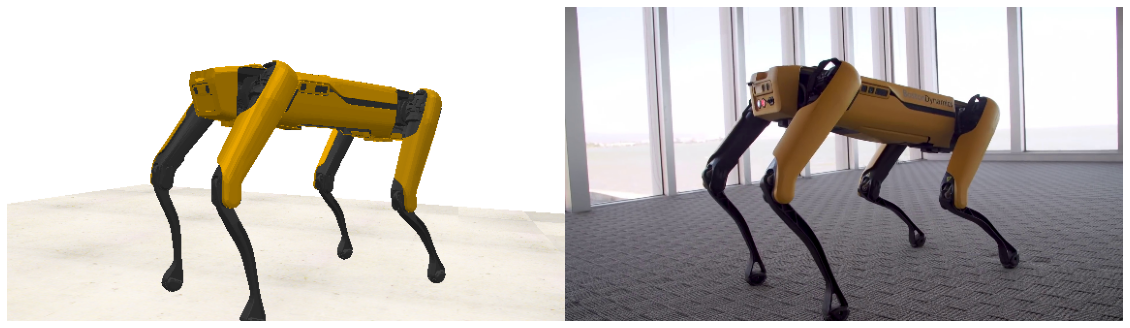

In [7]:
idx = 100

# get real image
real_image = cv2.imread("../dataset/spot_dance/%d.jpg" % idx)
real_image = cv2.cvtColor(real_image, cv2.COLOR_BGR2RGB)
scaling = 0.25 * 1.2
real_image = cv2.resize(real_image,(int(real_image.shape[1]*scaling),int(real_image.shape[0]*scaling)))

# render syntehtic image
setting_pose_in_sim(idx)
sim_image = cam_8.capture_rgb() * 255
sim_image = sim_image.astype(int)
sim_image = sim_image[:real_image.shape[0],:real_image.shape[1]]

plt.figure(figsize = (20,10))
im = np.concatenate((sim_image,real_image),axis=1)
plt.imshow(im)
plt.axis('off')

(-0.5, 1151.5, 323.5, -0.5)

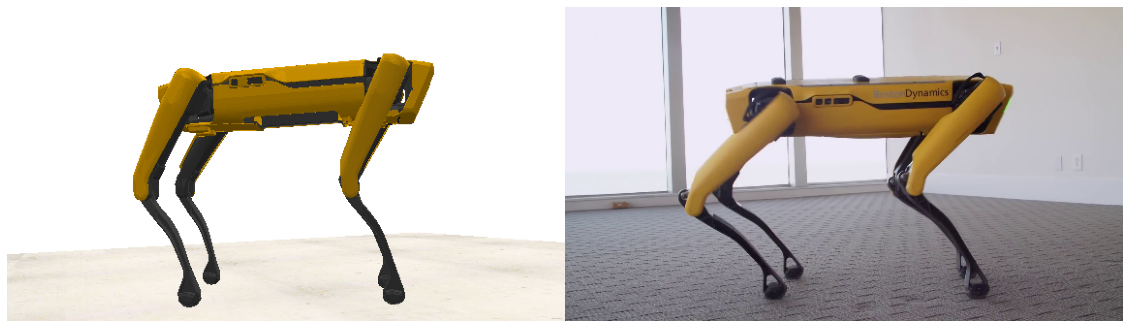

In [9]:
idx = 160

# get real image
real_image = cv2.imread("../dataset/spot_dance/%d.jpg" % idx)
real_image = cv2.cvtColor(real_image, cv2.COLOR_BGR2RGB)
scaling = 0.25 * 1.2
real_image = cv2.resize(real_image,(int(real_image.shape[1]*scaling),int(real_image.shape[0]*scaling)))

# render syntehtic image
setting_pose_in_sim(idx)
sim_image = cam_8.capture_rgb() * 255
sim_image = sim_image.astype(int)
sim_image = sim_image[:real_image.shape[0],:real_image.shape[1]]

plt.figure(figsize = (20,10))
im = np.concatenate((sim_image,real_image),axis=1)
plt.imshow(im)
plt.axis('off')